In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

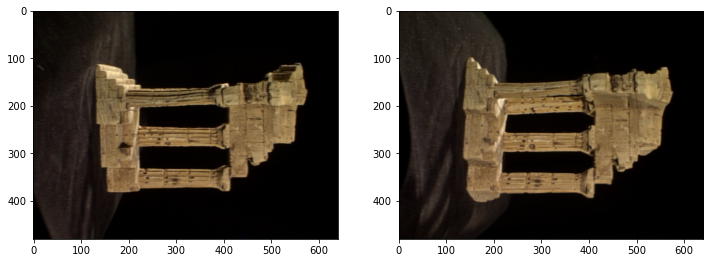

In [2]:
f = open('./assets/templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 = cv.imread('./assets/templeSparseRing/'+im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread('./assets/templeSparseRing/'+im2_fn, cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].set_aspect('equal')
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].set_aspect('equal')

plt.show()

# Q1

In [7]:
sift = cv.xfeatures2d.SIFT_create()
kp1, desc1 = sift.detectAndCompute(im1, None)
kp2, desc2 = sift.detectAndCompute(im2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

# Q2

In [9]:
good = []
pts1 = []
pts2 = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp1[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
E = K2.T @ F @ K1

print("F = ", F)
print("E = ", E)

F =  [[-2.00554528e-05  3.10542849e-05 -4.25730567e-02]
 [ 2.99667656e-06 -5.71912972e-07 -5.31507044e-04]
 [ 5.02353259e-02 -1.54364010e-02  1.00000000e+00]]
E =  [[-4.63605087e+01  7.20452689e+01 -6.22905597e+01]
 [ 6.95222476e+00 -1.33162547e+00  3.55931521e-01]
 [ 6.82841303e+01 -9.44418843e+00  4.79393285e-02]]


# Q3

In [10]:
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)
print("R = ", R)
print("t= ", t)

R =  [[ 0.96827929  0.1109906  -0.22386671]
 [ 0.11117276  0.61100675  0.78378018]
 [ 0.2237763  -0.78380599  0.57928605]]
t=  [[-0.00561168]
 [-0.9952181 ]
 [ 0.09751636]]


# Q4

In [13]:
R_t_1 = np.concatenate((R1, t1), axis=1)
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_, t2_), axis=1)

P1 = K1 @ np.hstack((R1, t1))
P2_ = K2 @ R_t_2

# Q5

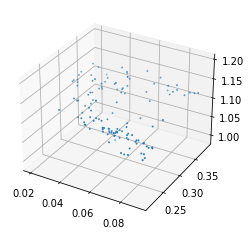

In [15]:
points4d = cv.triangulatePoints(P1, P2_, pts1.T, pts2.T)
points4d /= points4d[3,:]

X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, cmap='gray')

plt.show()